# Capstone 2 - Predicting Water Pump Condition in Tanzania Model

Kenneth Liao

---

## Background

The UN publishes and reviews a list of least developed countries (LDC) every 3 years. LDCs are “low-income countries confronting severe structural impediments to sustainable development. They are highly vulnerable to economic and environmental shocks and have low levels of human assets.”$^{1}$. Tanzania has been classified as an LDC since the UN published the first list of LDCs in 1971$^{2}$. A common challenge of LDCs is a lack of infrastructure to support the development of the nation, including access to education and healthcare, waste management, and potable water.

According to UNICEF, as of 2017, more than 24 million Tanzanians lacked access to basic drinking water$^{3}$. This corresponds to only 56.7% of the country’s population having access to basic drinking water. Outside of developed urban areas, much of the potable water is accessed via water pumps. 

Taarifa is an open-source platform for crowd-sourced reporting and triaging of infrastructure related issues. Together with the Tanzanian Ministry of Water, data has been collected for thousands of water pumps throughout Tanzania. The goal of this project is to be able to predict the condition of these water pumps to improve maintenance, reduce pump downtime, and ensure basic water access for tens of millions of Tanzanians.

**References**

1. https://www.un.org/development/desa/dpad/least-developed-country-category.html
2. https://www.un.org/development/desa/dpad/wp-content/uploads/sites/45/publication/ldc_list.pdf
3. https://washwatch.org/en/countries/tanzania/summary/statistics/


### Problem Description

Predict the operating condition of water pumps in Tanzania given various metadata on each water pump.

### Strategy

The strategy will be to implement a Random Forest model for multiclass classification of the state of water pumps.

### Data

The dataset is provided by Taarifa, together with the Tanzanian Ministry of Water and is hosted by DrivenData.org:

https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/page/23/

---

We first import the necessary libraries and the cleaned datasets.

In [55]:
import scipy
import pandas as pd
import numpy as np
import plotly.graph_objs as go
from plotly.offline import iplot, plot, init_notebook_mode
from config import credentials
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.metrics import make_scorer, confusion_matrix, f1_score, recall_score, accuracy_score, precision_score
from sklearn.tree import export_graphviz
from IPython.display import Image
from subprocess import call
from sklearn.externals import joblib

init_notebook_mode(connected=True)

In [2]:
# load datasets
X_train = pd.read_pickle('../data/X_train.pkl')
y_train = pd.read_pickle('../data/y_train.pkl')
y_test = pd.read_pickle('../data/y_test.pkl')

# save column names
features = X_train.columns

# load sparse versions of X_train & X_test
X_train_s = scipy.sparse.load_npz('../data/X_train_s.npz')
X_test_s = scipy.sparse.load_npz('../data/X_test_s.npz')

In [3]:
# create class label mapping
labels = {0: 'functional', 1: 'functional needs repair', 2: 'non functional'}
labels_list = list(labels.values())

In [4]:
class_counts = dict(y_train.value_counts())
class_counts

{0: 21540, 2: 15366, 1: 2892}

## Measuring Success

In classification models it's typical to plot the receiver operating characteristic (ROC) curves and compute the area under the curve (AUC) to compare the efficacy of various models. This requires computing the sensitivity and specificity of the model which are defined below. Note that specificity is also known as recall.

<br>

\begin{equation*}
Sensitivity | Recall = \frac{True Positive}{(True Positive + False Negative)}
\end{equation*}

<br>

\begin{equation*}
Specificity = \frac{True Negative}{(True Negative + False Positive)}
\end{equation*}

<br>

These are not good metrics for classfication problems with imbalanced data. For example, if the true class comprises 99% of the data with only 1% being false, then simply guessing true for all of the data would give you 0.99 Sensitivity and 0 specificity, making your model look extremely good. However, this could be a big issue if getting that 1% correct is critical, such as in the case of classifying cancer.

For imbalanced data it's therefore more appropriate to compute the precision and recall curves which focus on the true class.

<br>


\begin{equation*}
Precision = \frac{True Positive}{(True Positive + False Positive)}
\end{equation*}

<br>

\begin{equation*}
F1 = \frac{2 * (Precision * Recall)}{(Precision + Recall)}
\end{equation*}

<br>

We're interested in predicting which pumps are functioning normally, which pumps are functioning but need to be repaired, and which pumps are completely non functioning. If a pump is non functional, it requires immediate attention as the population dependent on that water source cannot access clean water. Therefore, it's most critical that we predict this class with high recall. That is, for non functional pumps, we want to minimize the number of pumps we classify as being functional when they are actually non functional (false negatives). Of course if we took this to the extreme and assumed all pumps are non functional, we would have perfect recall but very low precision. This would be impractical because we would have to essentially send surveyors to every pump anyway to check their status, in which case the model is useless. With this in mind, the next step is to try to optimize this model to improve the recall of the non functional group without lowing too much precision.

Below I've created a function to report the precision, recall, and f1 scores for the model's predictions.

In [5]:
def score(y_test, y_pred):
    """
    Compute precision, recall, and f1-scores.
    """
    scores = pd.DataFrame({'precision': precision_score(y_test, y_pred, average=None),
             'recall': recall_score(y_test, y_pred, average=None),
            'f1-score': f1_score(y_test, y_pred, average=None)},
            index=labels_list).T
    return scores

### Out-of-box Random Forest

I'll start by building a baseline for which we can compare our model's results to. Recall that the majority class was **functional** which comprised 54.3% of the data. Let's see what the precision, recall, and f1-score metrics would look like for an out-of-box random forest model.

In [7]:
%%time
# define and train the model
model = RandomForestClassifier(n_jobs=-1, random_state=42)
model.fit(X_train_s, y_train)

C:\Users\Kenny\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.



Wall time: 3.49 s


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
                       oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [8]:
# get the predicted labels from the model
y_pred = model.predict(X_test_s)

Let's look at the confusion matrix for the model.

In [9]:
cols = pd.MultiIndex.from_tuples(('Actual', i) for i in labels_list)
rows = pd.MultiIndex.from_tuples(('Predicted', i) for i in labels_list)
cm = pd.DataFrame(confusion_matrix(y_test, y_pred), index=rows, columns=cols)
cm

Actual                          \
                                  functional functional needs repair   
Predicted functional                    9494                     278   
          functional needs repair        737                     469   
          non functional                1753                     149   

                                                  
                                  non functional  
Predicted functional                         947  
          functional needs repair            219  
          non functional                    5556

From this summary it's easy to see that the majority of functional pumps were correctly classified as being functional. We were less accurate in correctly classifying the non functional pumps and even worse at correctly classifying the functional pumps needing repair. Let's explore this more by computing the precision, recall, and f1 scores for this data.

In [10]:
score(y_test, y_pred)

,functional,functional needs repair,non functional
precision,0.792223,0.523438,0.826540
recall,0.885717,0.329123,0.744972
f1-score,0.836365,0.404136,0.783639


The f1_score is highest for the functional class, followed by the non functional class. The recall for the non functional class is 0.745. This means that out of all of our predictions for non functional pumps, we were correct 74.5% the time. This is really not a bad start!

### Optimized Random Forest

In [8]:
clf = RandomForestClassifier(random_state=42, n_jobs=-1)

param_grid = {'max_depth':[10],
              'max_leaf_nodes':[10,100,500,1000],
             'n_estimators': [128],
             'class_weight': ['balanced']}

scorers = {
    'precision_score': make_scorer(precision_score, average='weighted'),
    'recall_score': make_scorer(recall_score, average='weighted'),
    'f1_score': make_scorer(f1_score, average='weighted')
}

In [16]:
def grid_search(refit_score='recall_score'):
    skf = StratifiedKFold(n_splits=3)
    
    gs = GridSearchCV(clf, param_grid, scoring=scorers, refit=refit_score,
                           cv=skf, return_train_score=True, n_jobs=-1)
    
    gs.fit(X_train_s, y_train.values)
    
    y_pred = gs.predict(X_test_s)
    
    print(gs.best_params_)

    return gs

In [17]:
%%time
results = grid_search(refit_score='f1_score')

{'class_weight': 'balanced', 'max_depth': 10, 'max_leaf_nodes': 500, 'n_estimators': 128}
Wall time: 15.3 s


In [18]:
score(y_test, results.predict(X_test_s))

,functional,functional needs repair,non functional
precision,0.771224,0.182479,0.653906
recall,0.552570,0.616842,0.622955
f1-score,0.643839,0.281640,0.638055


In [23]:
{k: 1/v for k,v in class_counts.items()}

{0: 4.642525533890436e-05, 2: 6.507874528179097e-05, 1: 0.00034578146611341634}

In [20]:
inverse_freq_weights = {k: 1/v for k,v in class_counts.items()}
bias_non_functional = {0: 4e-05, 2: 6.508e-04, 1: 0.0004}
bias_non_functional2 = {0: 1e-05, 2: 6.508e-04, 1: 0.0005}

random_grid = {'max_depth':range(2,50),
               'n_estimators': range(50,150),
               'min_samples_leaf': range(1,10),
               'max_features': ['auto', 'log2', 0.1, 0.2],
               'class_weight': ['balanced', inverse_freq_weights, 
                                bias_non_functional, bias_non_functional2]}

grid_size = 0
for i in random_grid.values():
    grid_size+=len(i)

def random_search(clf, refit_score='f1_score'):
    
    skf = StratifiedKFold(n_splits=5, random_state=42)
    
    rs = RandomizedSearchCV(clf, random_grid, scoring=scorers, refit='f1_score',
                           cv=skf, return_train_score=True, n_jobs=12, 
                            random_state=42, n_iter=int(grid_size/2))
    
    rs.fit(X_train_s, y_train.values)
    
    y_pred = rs.predict(X_test_s)
    
    print(rs.best_params_)

    return rs

In [21]:
%%time
clf = RandomForestClassifier(random_state=42, n_jobs=12)

rs = random_search(clf)

{'n_estimators': 86, 'min_samples_leaf': 1, 'max_features': 0.1, 'max_depth': 29, 'class_weight': {0: 4.642525533890436e-05, 2: 6.507874528179097e-05, 1: 0.00034578146611341634}}
Wall time: 49min 19s


In [22]:
score(y_test, rs.predict(X_test_s))

,functional,functional needs repair,non functional
precision,0.822424,0.460870,0.855117
recall,0.869764,0.483509,0.776348
f1-score,0.845432,0.471918,0.813831


Save the model to a pickle object.

In [28]:
# save the model to disk
filename = 'random_search.pkl'
joblib.dump(rs, filename)

['random_search.pkl']

Load the model back.

In [29]:
loaded_model = joblib.load(filename)

In [35]:
rs.cv_results_

{'mean_fit_time': array([161.8351532 ,   2.38737078,  98.42889857,  34.69515214,
        221.94118099, 174.56851258, 108.45840616,   8.28132744,
          6.18982463,  10.40646086,   3.5588346 ,   4.93047552,
          2.47044539,   4.81657767,   2.10731454,   1.00471201,
          5.33905263,   2.0698791 , 164.80903692,   2.4584331 ,
        145.10852666,   4.56074586,   4.29930787,   0.94085336,
          7.5576683 ,   2.56933551, 240.22499723,  10.41346722,
        244.48167777, 149.3878191 , 122.25094676,  96.46410127,
         72.6352375 ,   2.69805307,   8.52134495, 102.87473078,
          3.13064899,  10.87188277, 152.72044759,   4.26047316,
         89.41329002,   4.62059822,   1.20749059, 105.05091019,
         56.56442513,  28.91388831,   7.91939759, 190.9421967 ,
          2.35053663,   2.17437377,   2.73908992, 229.67060771,
          7.49321179,  69.75922265,  74.29474568,  66.6193666 ,
         79.35414739, 122.60927439,   8.39542923, 209.58174505,
        113.0363667 ,  

In [30]:
loaded_model

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=False),
                   error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_...
                                        'max_features': ['auto', 'log2', 0

In [37]:
feat_importances = pd.DataFrame({'feature': features, 'importance': rs.best_estimator_.feature_importances_}).sort_values('importance', ascending=False).reset_index(drop=True)
feat_importances.head(10)

,feature,importance
0,quantity_dry,0.059877
1,longitude,0.054795
2,latitude,0.050642
3,gps_height,0.029240
4,years_since_install,0.025220
5,construction_year,0.023259
6,day_recorded,0.022262
7,population,0.021248
8,quantity_enough,0.015268
9,amount_tsh,0.013563


The top 10 most important features in the random forest model are shown above. 

Take the best model and now just play with the weights to try to improve the performance on non functional and needs repair

### Out-of-box Logistic Regression

In [12]:
%%time
clf = SGDClassifier(loss='log', random_state=42)

clf.fit(X_train_s, y_train)

Wall time: 15.3 s


SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=42, shuffle=True, tol=0.001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [13]:
y_pred = clf.predict(X_test_s)

In [14]:
score(y_test, y_pred)

,functional,functional needs repair,non functional
precision,0.742588,0.090700,0.837339
recall,0.301427,0.856842,0.200858
f1-score,0.428799,0.164036,0.323997


We can see that the out-of-box logistic regression model produced much poorer results.

In [67]:
inverse_freq_weights = {k: 1/v for k,v in class_counts.items()}
bias_non_functional = {0: 4e-05, 2: 6.508e-04, 1: 0.0004}
bias_non_functional2 = {0: 1e-05, 2: 6.508e-04, 1: 0.0005}

random_grid = {'class_weight': ['balanced', inverse_freq_weights, 
                                bias_non_functional, bias_non_functional2],
              'multi_class': ['multinomial'],
              'solver':['newton-cg', 'sag','saga','lbfgs'],
              'penalty':['l2']}

grid_size = 0
for i in random_grid.values():
    grid_size+=len(i)

def random_search(clf, refit_score='f1_score'):
    
    skf = StratifiedKFold(n_splits=5, random_state=42)
    
    rs = RandomizedSearchCV(clf, random_grid, scoring=scorers, refit='f1_score',
                           cv=skf, return_train_score=True, n_jobs=12, 
                            random_state=42, n_iter=int(np.sqrt(grid_size)))
    
    rs.fit(X_train_s, y_train.values)
    
    y_pred = rs.predict(X_test_s)
    
    print(rs.best_params_)

    return rs

In [65]:
%%time
clf = LogisticRegression(random_state=42, n_jobs=12)

lr_search = random_search(clf, refit_score='f1_score')

{'solver': 'newton-cg', 'penalty': 'l2', 'multi_class': 'multinomial', 'class_weight': 'balanced'}
Wall time: 8min 23s


In [66]:
y_pred = lr_search.predict(X_test_s)

score(y_test, y_pred)

,functional,functional needs repair,non functional
precision,0.824985,0.367195,0.799972
recall,0.792891,0.552982,0.767364
f1-score,0.808620,0.441333,0.783329


### Hyperparameter Tuning & Model Optimization

To optimize the model, I reduced the max_depth to 5 and increased the number of estimators to 10,000 to reduce overfitting the train data. I also played with the weights given to each class to emphasize the "non functional" class. The results of the model above shows that we were able to increase the recall of the "non functional" pumps from 0.74 to 0.75 by increasing the weight of that class. This is an improvement of 1% over the baseline model. However, the precision suffered and dropped from 0.83 to 0.6! The next step would be to run an exhaustive grid search to find the optimal model to improve the recall of "non functional" pumps while maintaining the f1-score to ensure we don't lose too much precision

The model found that the gps location (latitude, longitude, and height) of water pumps is critical in determining whether they are functioning or not. One feature which I engineered "years_since_install" was also among the top 5 most important features. This is not surprising since things manufactured goods tend to degrade over time, especially with high usage and weather.

### Interpretation

In [19]:
clf = RandomForestClassifier(random_state=42, max_depth=2, n_estimators=100, n_jobs=-1)

clf.fit(X_train_s, y_train.values)

estimator = clf.estimators_[50]

In [20]:
estimator

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
                       max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=1224821422, splitter='best')

In [25]:


# Export as dot file
export_graphviz(estimator, out_file='tree.dot', 
                feature_names = X_train.columns,
                class_names = labels_list,
                rounded = True, proportion = False, 
                precision = 2, filled = True)

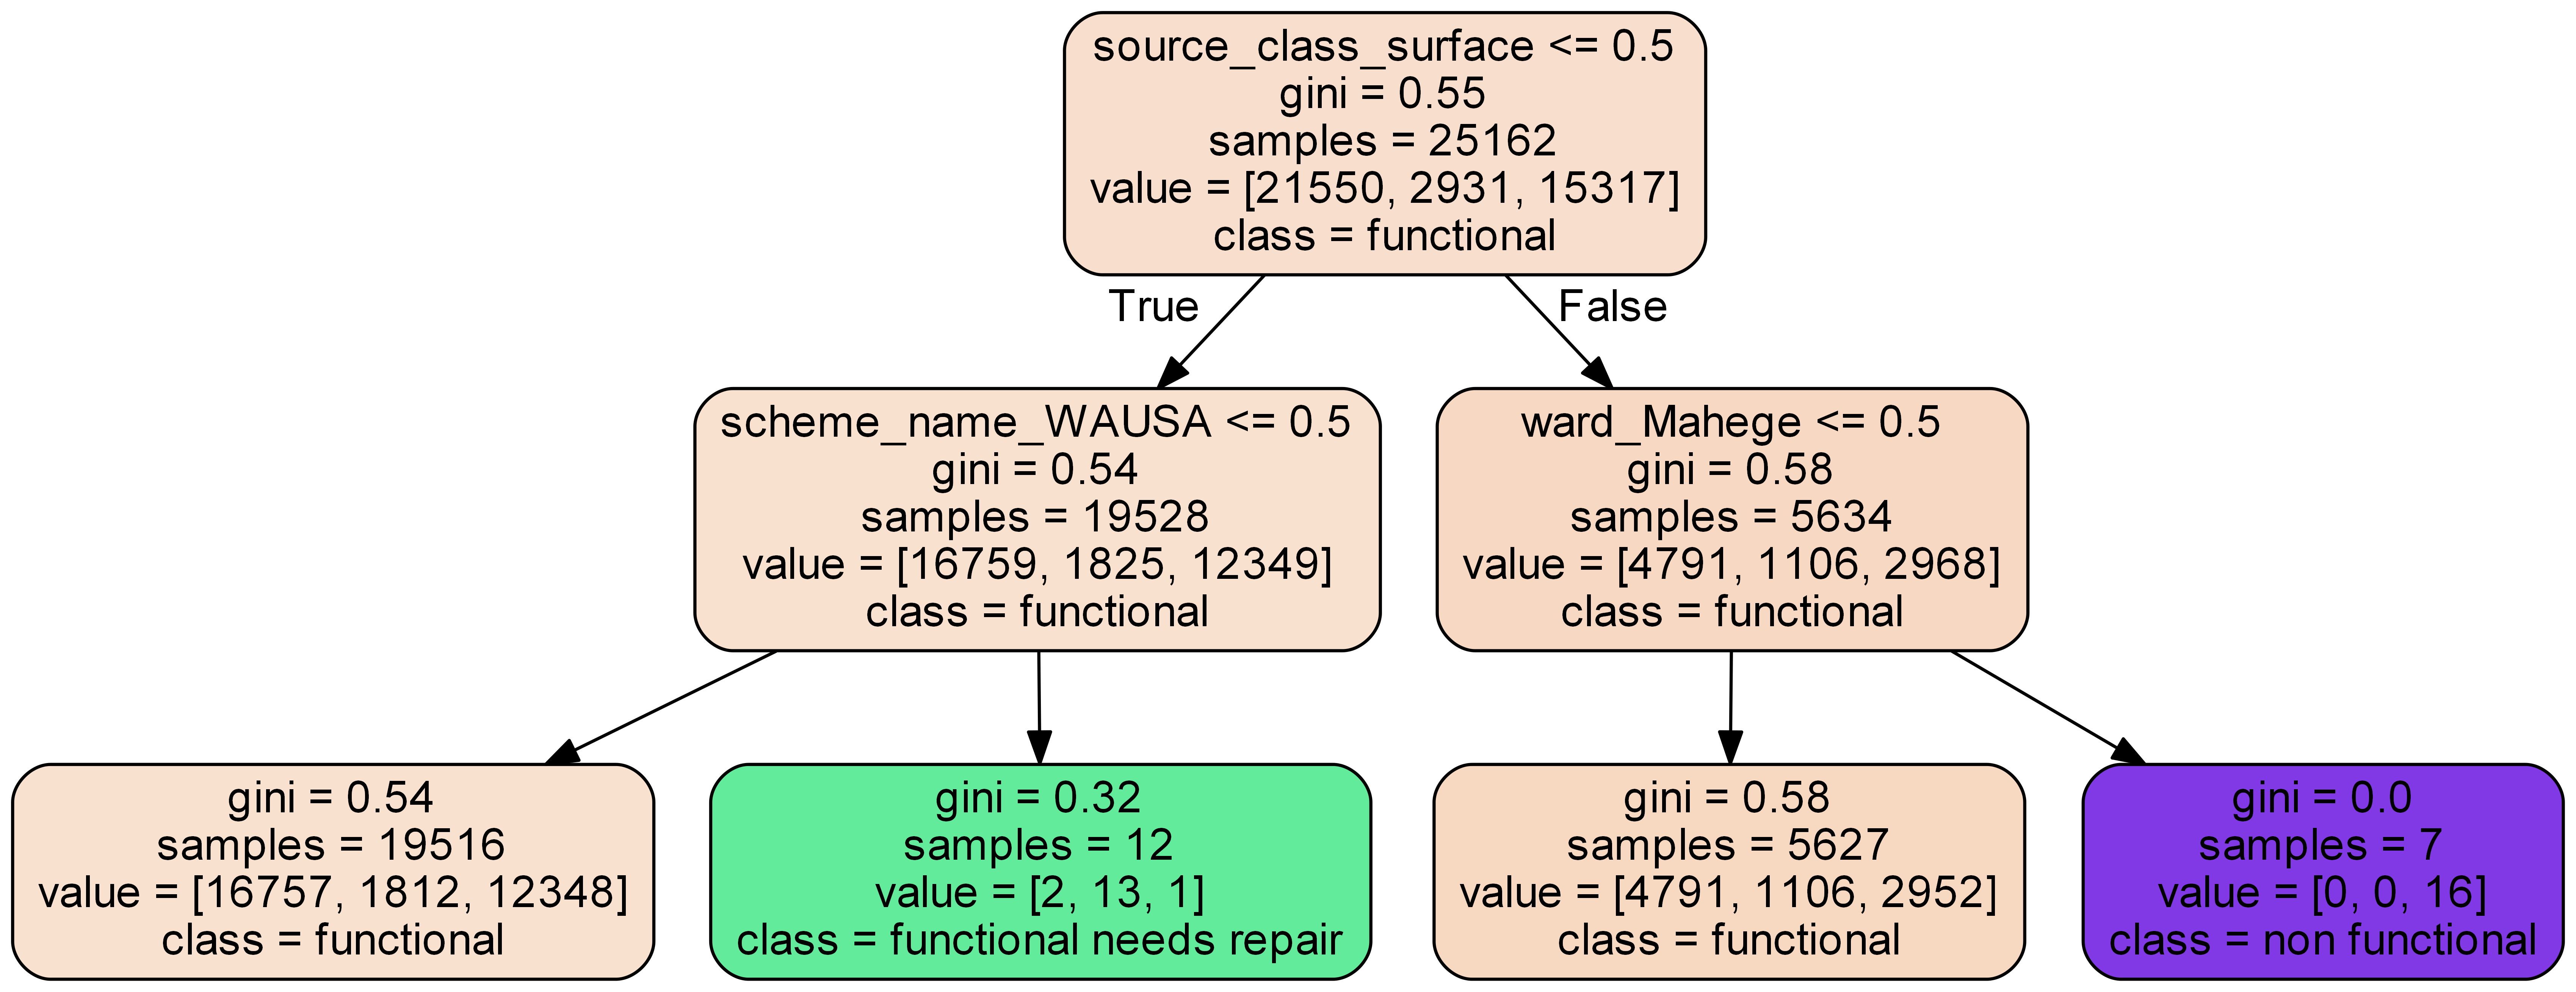

In [26]:
# Convert to png using system command (requires Graphviz)

call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in jupyter notebook

Image(filename = 'tree.png')

## Conlusions

I trained a Random Forest model to classify water pumps as "functional", "function needs repair", and non functional. I focused on improving the recall score for accurately predicting "non functional" pumps, as this class is the most critical in getting right. The model is able to predict "non functional" water pumps with a precision of and a recall of . This is a great start to accurately deploying resources where they are needed the most, and to ensure that Tanzanians have access to clean, potable water.

## Next Steps

Seeing how gps latitude and longitude were the two most important features in this model. I would like to explore this more by finding correlations between those two features and the other features. Why does the location matter? Are the "non functional" pumps clumped together around certain geographical regions? Why are those areas so different? The first step to answering these questions would be to plot the locations of failing pumps and explore how the rest of the features are stratified for these broken pumps.